In [ ]:
import jcopdl, luwiji
import numpy as np
import matplotlib.pyplot as pltpip
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

: 

<h2> Dataset & Dataloader

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
bs = 128
crop_size = 64  # input di cnn harus sama, standardnya 224

train_transforms = transforms.Compose([
    transforms.RandomRotation(15),
    # discale agar tidak terlalu zoom in
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# data test jangan di augmentasi
test_transforms = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder(
    "/content/data/train", transform=train_transforms)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder(
    "/content/data/test", transform=test_transforms)
# bisa di shuffle ataupun tidak
testloader = DataLoader(test_set, batch_size=bs, shuffle=True, num_workers=4)

In [ ]:
# sanity check
features, target = next(iter(trainloader))
features.shape

torch.Size([128, 3, 64, 64])

In [ ]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

In [ ]:
len(train_set), len(test_set)

(1000, 400)

In [ ]:
from collections import Counter

dict(Counter(train_set.targets))

{0: 500, 1: 500}

In [ ]:
from jcopdl.layers import conv_block, linear_block

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            # nn.conv2D(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2D(2, 2)
            conv_block(3, 8), # sudah conv, relu, pool
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            linear_block(1024, 256, dropout=0.1), # 1024 from 64 * (4*4) it's value of features in the last conv block
            linear_block(256, 2, activation='lsoftmax')
        )

    def forward(self, x):
        x = self.conv(x) # input ke feature extractor (cv)
        x = self.fc(x) # lalu masuk ke fc
        return x

In [ ]:
# simpan informasi penting yg mudah lupa

config = set_config({
    "batch_size": bs,
    "crop_size": crop_size
})

<h2> Training Preparation -> MCOC

In [ ]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

<h2> Training Loop

In [ ]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6912 | Test_cost  = 0.6866 | Train_score = 0.5400 | Test_score = 0.4975 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.6716 | Test_cost  = 0.6414 | Train_score = 0.6410 | Test_score = 0.6675 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    <function _M

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910><function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910><function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):



Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()            self._shutdown_workers()self._shutdown_workers()


Epoch     3
Train_cost  = 0.6097 | Test_cost  = 0.5769 | Train_score = 0.6890 | Test_score = 0.7075 |


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):
if w.is_alive():Traceback (most recent call last):


  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
  File "/usr/lib/python3.10/

Train:   0%|          | 0/8 [00:01<?, ?it/s]


self._shutdown_workers()can only test a child processException ignored in: Traceback (most recent call last):


<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
            self._shutdown_workers()
self._shutdown_workers()if w.is_alive():
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

Exception ignored in:       File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutd

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.5529 | Test_cost  = 0.5029 | Train_score = 0.7160 | Test_score = 0.7775 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.5465 | Test_cost  = 0.4981 | Train_score = 0.7330 | Test_score = 0.7500 |
==> EarlyStop patience =  1 | Best test_score: 0.7775


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.5321 | Test_cost  = 0.4605 | Train_score = 0.7260 | Test_score = 0.8100 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


Epoch     7
Train_cost  = 0.5031 | Test_cost  = 0.4493 | Train_score = 0.7590 | Test_score = 0.8100 |
==> EarlyStop patience =  1 | Best test_score: 0.8100


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>Exception ignored in: 
Traceback (most recent call last):
    Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):


Train:   0%|          | 0/8 [00:00<?, ?it/s]

self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
    self._shutdown_workers()    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
if w.is_alive():
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

        assert self._parent_pid == os.getpid(), 'can only test a chil

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():
    
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

Exception ignored in:  


Epoch     8
Train_cost  = 0.4660 | Test_cost  = 0.4341 | Train_score = 0.7750 | Test_score = 0.8100 |
==> EarlyStop patience =  2 | Best test_score: 0.8100


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.4484 | Test_cost  = 0.4311 | Train_score = 0.7890 | Test_score = 0.8125 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.4376 | Test_cost  = 0.4040 | Train_score = 0.7950 | Test_score = 0.8175 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.4349 | Test_cost  = 0.4204 | Train_score = 0.8090 | Test_score = 0.8150 |
==> EarlyStop patience =  1 | Best test_score: 0.8175


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.4362 | Test_cost  = 0.4124 | Train_score = 0.8010 | Test_score = 0.8200 |


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910><function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>


Train:   0%|          | 0/8 [00:00<?, ?it/s]


Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>    if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>

Traceback (most recent call last):
if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__


Test:   0%|          | 0/4 [00:00<?, ?it/s]

can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910><function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>if w.is_alive():Exception ignored in: 


  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line


Epoch    13
Train_cost  = 0.4282 | Test_cost  = 0.4087 | Train_score = 0.7870 | Test_score = 0.8225 |



  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
          File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    if w.is_alive():
AssertionError
if w.is_alive():: can only test a child process
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

    Exception ignored in:   File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child process'
    AssertionErrorassert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
AssertionError: can only test a child process

Traceback (most recent call last):
:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
can only test a child process
    self._shu

Train:   0%|          | 0/8 [00:00<?, ?it/s]

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
AssertionError    if w.is_alive():: can only test a child process

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.4181 | Test_cost  = 0.3871 | Train_score = 0.8160 | Test_score = 0.8225 |
==> EarlyStop patience =  1 | Best test_score: 0.8225


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.3990 | Test_cost  = 0.3967 | Train_score = 0.8210 | Test_score = 0.8300 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.4066 | Test_cost  = 0.3931 | Train_score = 0.8070 | Test_score = 0.8375 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.4394 | Test_cost  = 0.4622 | Train_score = 0.7920 | Test_score = 0.7525 |
==> EarlyStop patience =  1 | Best test_score: 0.8375


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>Traceback (most recent call last):



Train:   0%|          | 0/8 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
self._shutdown_workers()Traceback (most recent call last):


  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:       File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>if w.is_alive():self._shutdown_workers()


  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

  File "/usr/lib/python3.10/m

Test:   0%|          | 0/4 [00:01<?, ?it/s]



<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
AssertionError: 
    assert self._parent_pid == os.getpid(), 'can only test a child process'can only test a child process
Traceback (most recent call last):

AssertionError  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
:     self._shutdown_workers()
can only test a child process  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        assert self._parent_pid == os.getpid(), 'can only test a child proc


Epoch    18
Train_cost  = 0.4080 | Test_cost  = 0.4213 | Train_score = 0.8080 | Test_score = 0.8100 |
==> EarlyStop patience =  2 | Best test_score: 0.8375


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.4154 | Test_cost  = 0.3815 | Train_score = 0.8050 | Test_score = 0.8275 |
==> EarlyStop patience =  3 | Best test_score: 0.8375


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.4022 | Test_cost  = 0.3753 | Train_score = 0.8190 | Test_score = 0.8500 |


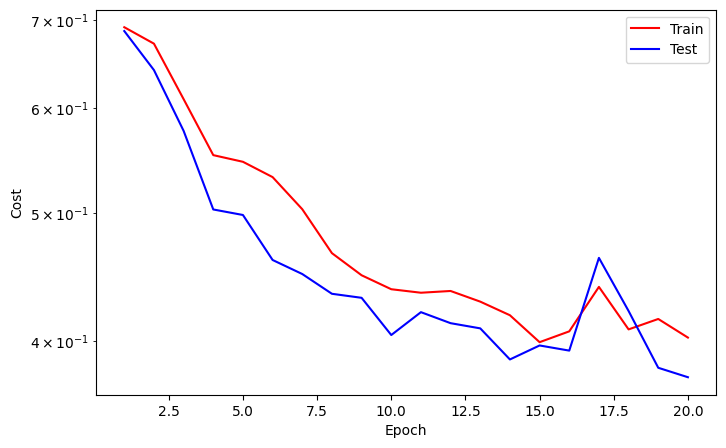

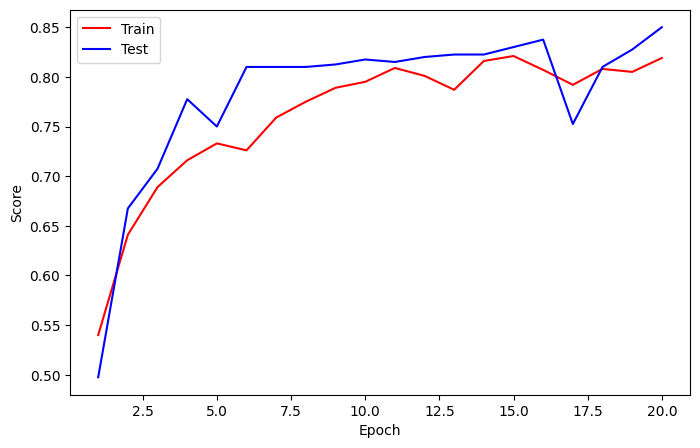

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.3812 | Test_cost  = 0.3610 | Train_score = 0.8350 | Test_score = 0.8575 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: if w.is_alive():    
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.3722 | Test_cost  = 0.3662 | Train_score = 0.8360 | Test_score = 0.8575 |
==> EarlyStop patience =  1 | Best test_score: 0.8575


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.3780 | Test_cost  = 0.3630 | Train_score = 0.8300 | Test_score = 0.8500 |
==> EarlyStop patience =  2 | Best test_score: 0.8575


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.3647 | Test_cost  = 0.3404 | Train_score = 0.8370 | Test_score = 0.8525 |
==> EarlyStop patience =  3 | Best test_score: 0.8575


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.3514 | Test_cost  = 0.3316 | Train_score = 0.8300 | Test_score = 0.8625 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


Epoch    26
Train_cost  = 0.3399 | Test_cost  = 0.3271 | Train_score = 0.8480 | Test_score = 0.8675 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.3343 | Test_cost  = 0.3127 | Train_score = 0.8520 | Test_score = 0.8675 |
==> EarlyStop patience =  1 | Best test_score: 0.8675


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.3347 | Test_cost  = 0.3253 | Train_score = 0.8500 | Test_score = 0.8700 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.3531 | Test_cost  = 0.3939 | Train_score = 0.8430 | Test_score = 0.8000 |
==> EarlyStop patience =  1 | Best test_score: 0.8700


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.3311 | Test_cost  = 0.3023 | Train_score = 0.8590 | Test_score = 0.8750 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'    
self._shutdown_workers()AssertionError
: Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
can only test a child process    <function _Mu

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.3301 | Test_cost  = 0.3053 | Train_score = 0.8590 | Test_score = 0.8725 |
==> EarlyStop patience =  1 | Best test_score: 0.8750


Train:   0%|          | 0/8 [01:19<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.3178 | Test_cost  = 0.3245 | Train_score = 0.8610 | Test_score = 0.8575 |
==> EarlyStop patience =  2 | Best test_score: 0.8750


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.3357 | Test_cost  = 0.2988 | Train_score = 0.8530 | Test_score = 0.8850 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.3122 | Test_cost  = 0.2931 | Train_score = 0.8630 | Test_score = 0.8925 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/


Epoch    35
Train_cost  = 0.3049 | Test_cost  = 0.3079 | Train_score = 0.8690 | Test_score = 0.8725 |
==> EarlyStop patience =  1 | Best test_score: 0.8925


Exception ignored in: 

Train:   0%|          | 0/8 [00:00<?, ?it/s]

<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910><function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.3027 | Test_cost  = 0.2866 | Train_score = 0.8650 | Test_score = 0.8900 |
==> EarlyStop patience =  2 | Best test_score: 0.8925


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.3232 | Test_cost  = 0.3084 | Train_score = 0.8540 | Test_score = 0.8625 |
==> EarlyStop patience =  3 | Best test_score: 0.8925


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.3146 | Test_cost  = 0.2890 | Train_score = 0.8670 | Test_score = 0.8825 |
==> EarlyStop patience =  4 | Best test_score: 0.8925


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.2941 | Test_cost  = 0.3181 | Train_score = 0.8750 | Test_score = 0.8475 |
==> EarlyStop patience =  5 | Best test_score: 0.8925
==> Execute Early Stopping at epoch: 39 | Best test_score: 0.8925
==> Best model is saved at model


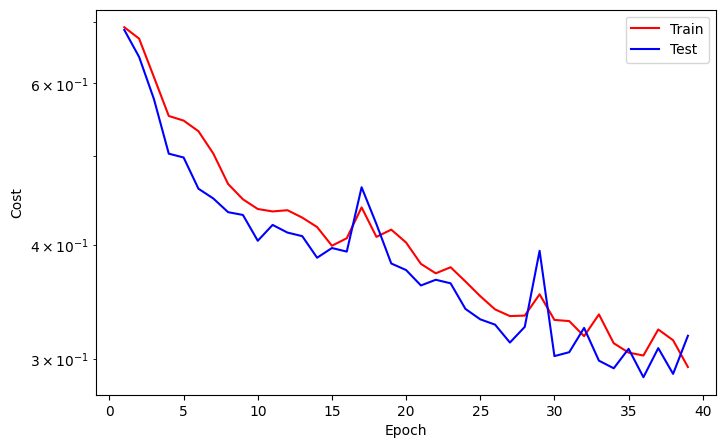

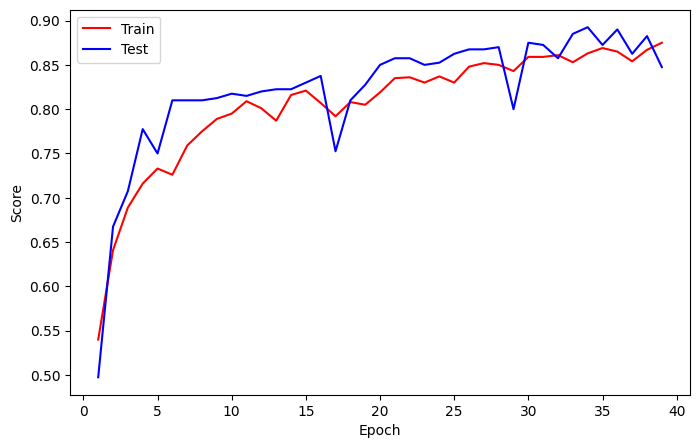

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 0.3152 | Test_cost  = 0.2704 | Train_score = 0.8620 | Test_score = 0.8900 |


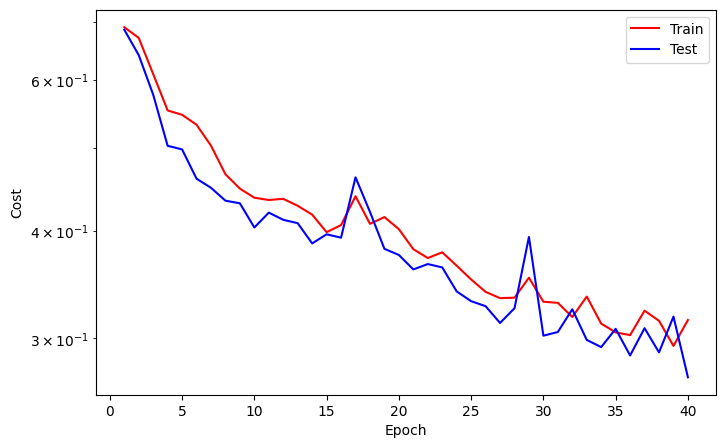

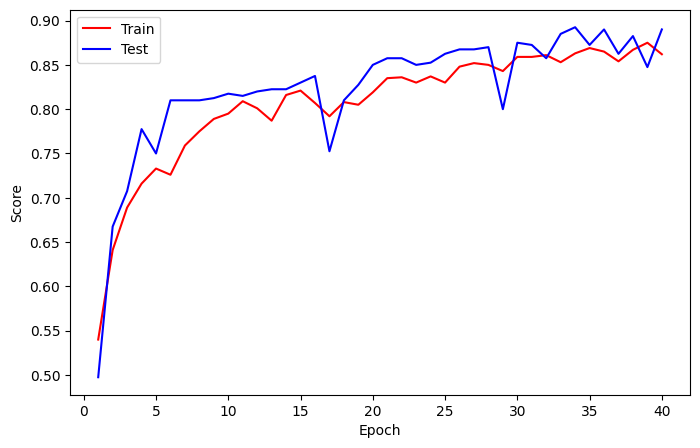

==> EarlyStop patience =  6 | Best test_score: 0.8925
==> Execute Early Stopping at epoch: 40 | Best test_score: 0.8925
==> Best model is saved at model


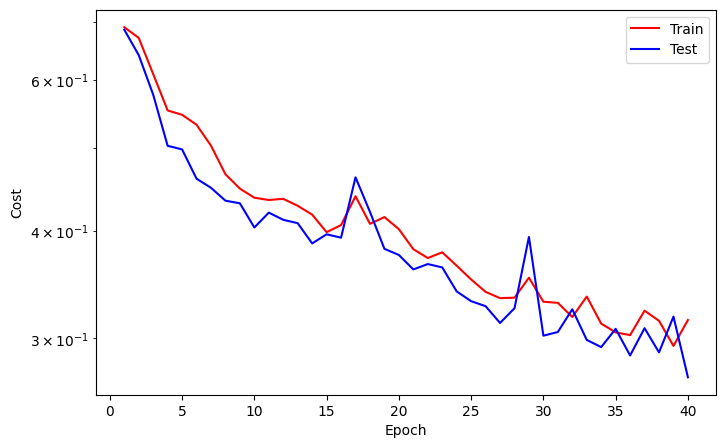

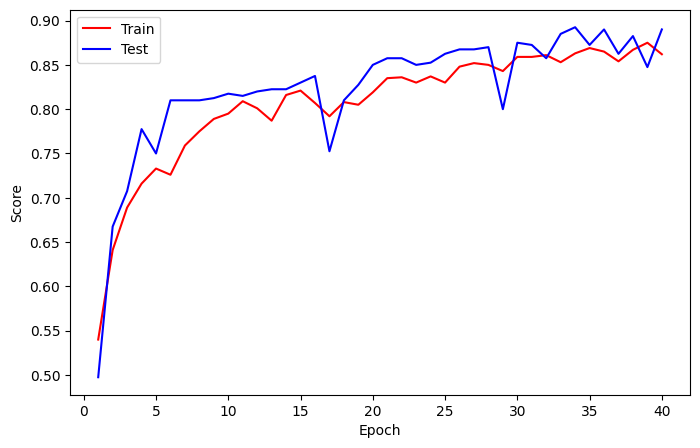

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 0.3015 | Test_cost  = 0.2900 | Train_score = 0.8780 | Test_score = 0.8725 |
==> EarlyStop patience =  7 | Best test_score: 0.8925
==> Execute Early Stopping at epoch: 41 | Best test_score: 0.8925
==> Best model is saved at model


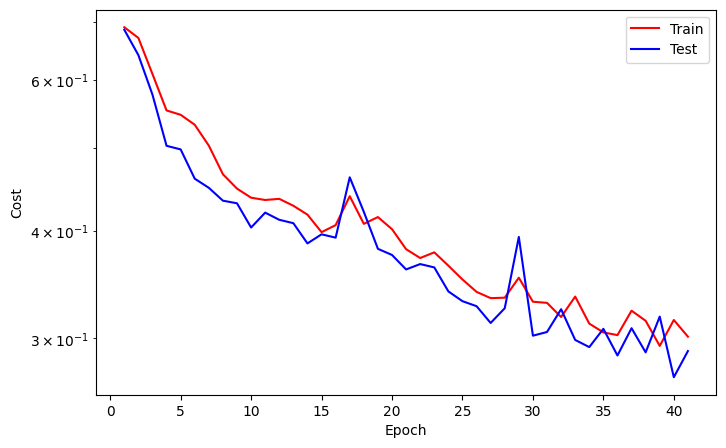

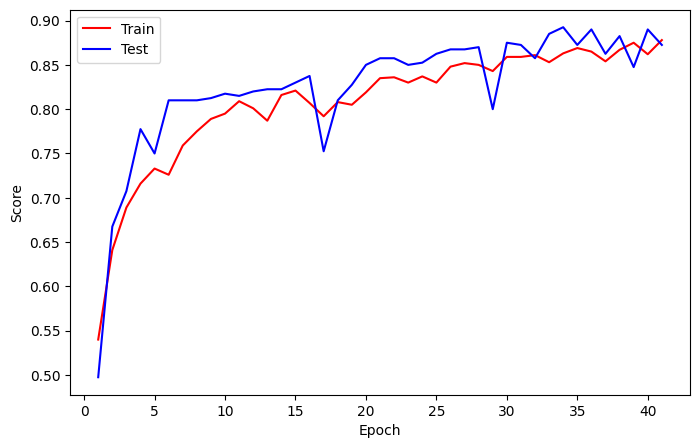

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 0.2889 | Test_cost  = 0.2915 | Train_score = 0.8710 | Test_score = 0.8850 |
==> EarlyStop patience =  8 | Best test_score: 0.8925
==> Execute Early Stopping at epoch: 42 | Best test_score: 0.8925
==> Best model is saved at model


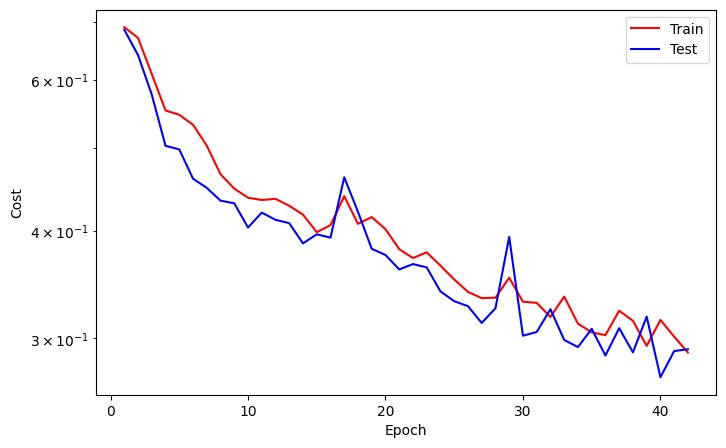

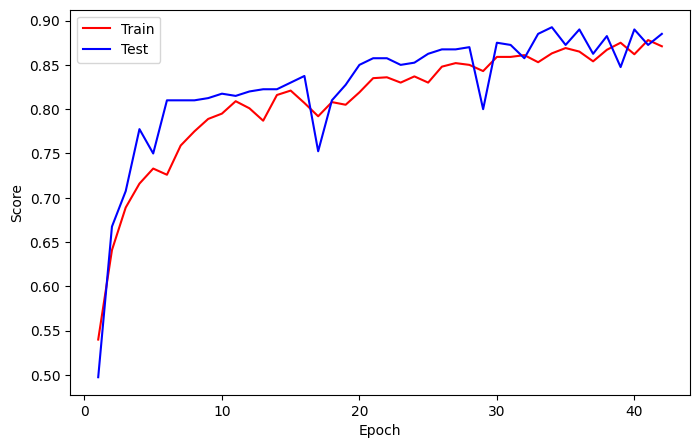

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 0.2756 | Test_cost  = 0.2712 | Train_score = 0.8790 | Test_score = 0.8850 |
==> EarlyStop patience =  9 | Best test_score: 0.8925
==> Execute Early Stopping at epoch: 43 | Best test_score: 0.8925
==> Best model is saved at model


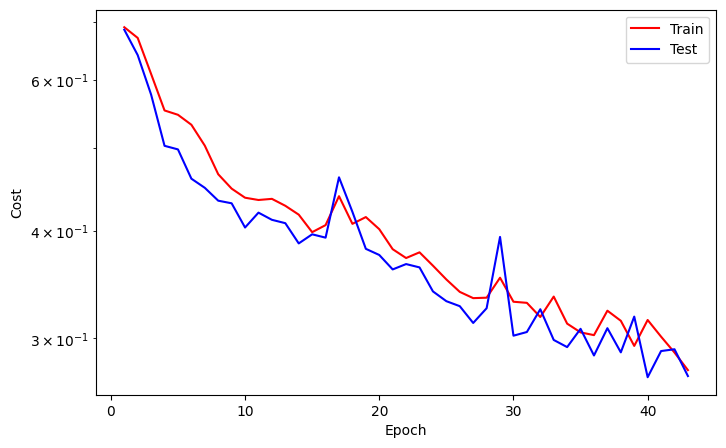

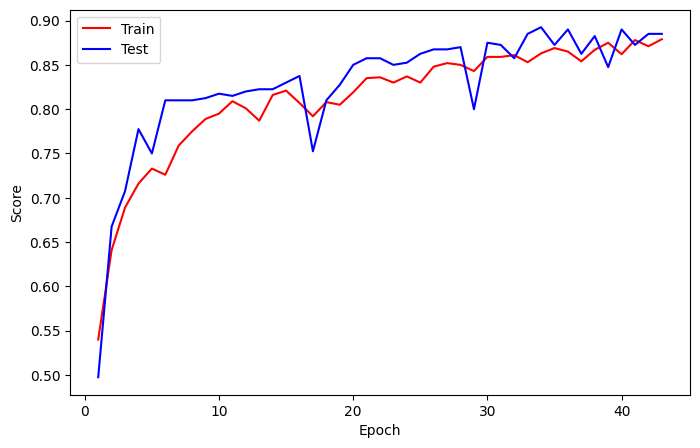

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 0.2651 | Test_cost  = 0.2679 | Train_score = 0.8950 | Test_score = 0.8900 |
==> EarlyStop patience = 10 | Best test_score: 0.8925
==> Execute Early Stopping at epoch: 44 | Best test_score: 0.8925
==> Best model is saved at model


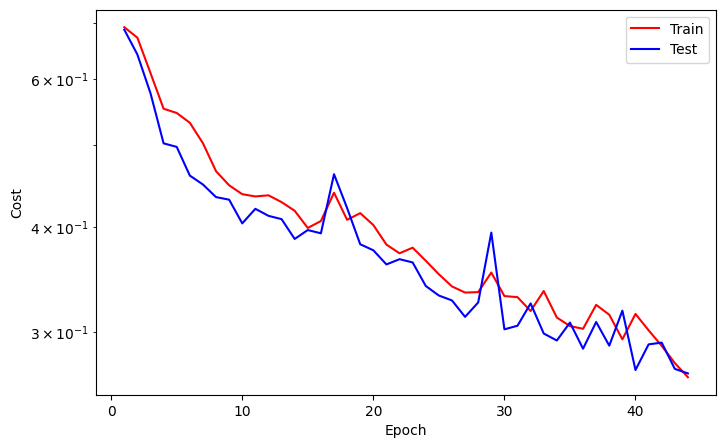

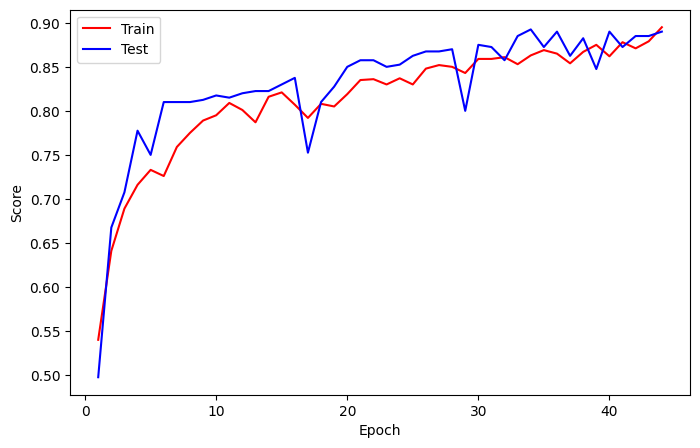

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 0.2560 | Test_cost  = 0.2510 | Train_score = 0.8960 | Test_score = 0.8975 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 0.3215 | Test_cost  = 0.3747 | Train_score = 0.8540 | Test_score = 0.8025 |
==> EarlyStop patience =  1 | Best test_score: 0.8975


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 0.3008 | Test_cost  = 0.2722 | Train_score = 0.8710 | Test_score = 0.8850 |
==> EarlyStop patience =  2 | Best test_score: 0.8975


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 0.2937 | Test_cost  = 0.2996 | Train_score = 0.8800 | Test_score = 0.8525 |
==> EarlyStop patience =  3 | Best test_score: 0.8975


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/8 [01:20<?, ?it/s]


Epoch    49
Train_cost  = 0.2860 | Test_cost  = 0.2602 | Train_score = 0.8820 | Test_score = 0.8925 |
==> EarlyStop patience =  4 | Best test_score: 0.8975


Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 0.2752 | Test_cost  = 0.2668 | Train_score = 0.8880 | Test_score = 0.8950 |
==> EarlyStop patience =  5 | Best test_score: 0.8975
==> Execute Early Stopping at epoch: 50 | Best test_score: 0.8975
==> Best model is saved at model


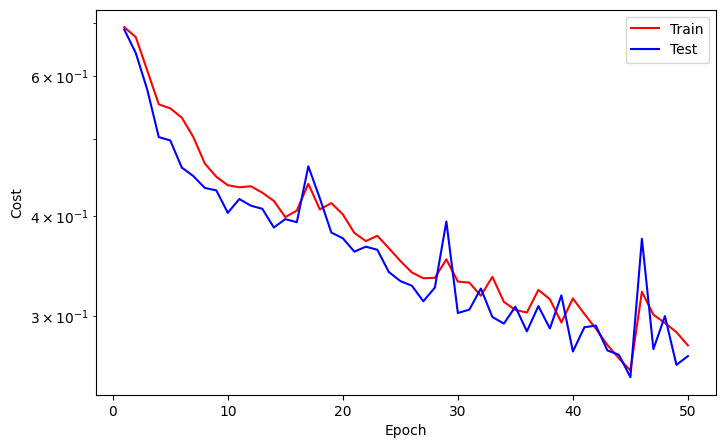

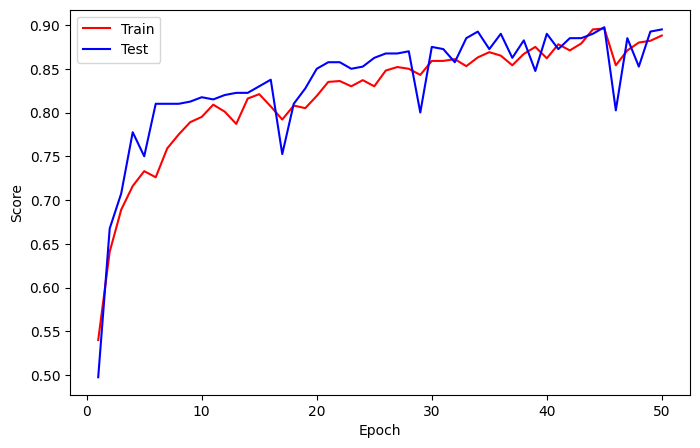

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 0.2477 | Test_cost  = 0.2439 | Train_score = 0.8990 | Test_score = 0.8975 |
==> EarlyStop patience =  6 | Best test_score: 0.8975
==> Execute Early Stopping at epoch: 51 | Best test_score: 0.8975
==> Best model is saved at model


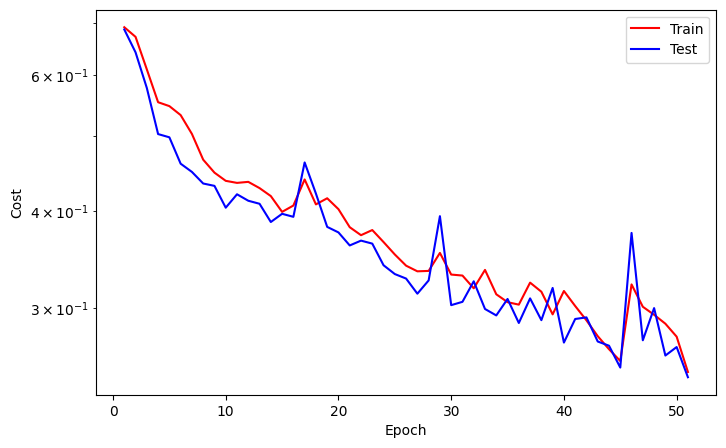

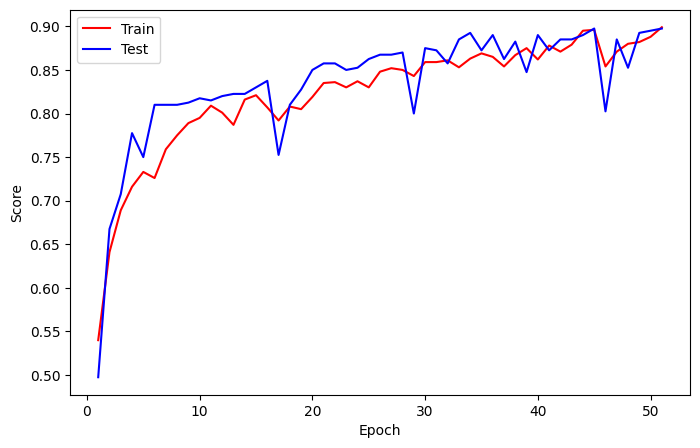

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 0.2616 | Test_cost  = 0.2527 | Train_score = 0.8840 | Test_score = 0.8950 |
==> EarlyStop patience =  7 | Best test_score: 0.8975
==> Execute Early Stopping at epoch: 52 | Best test_score: 0.8975
==> Best model is saved at model


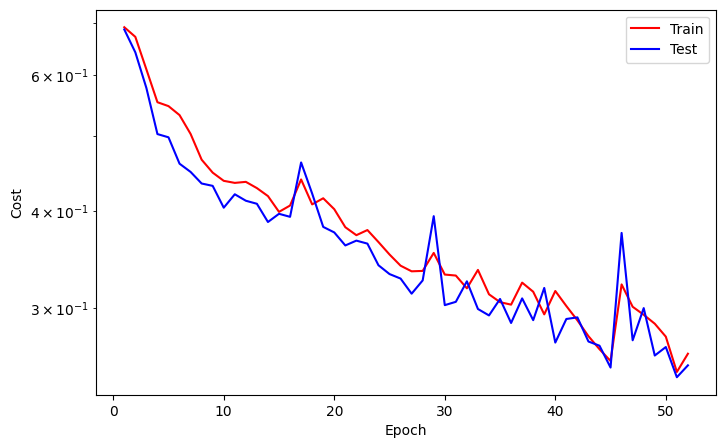

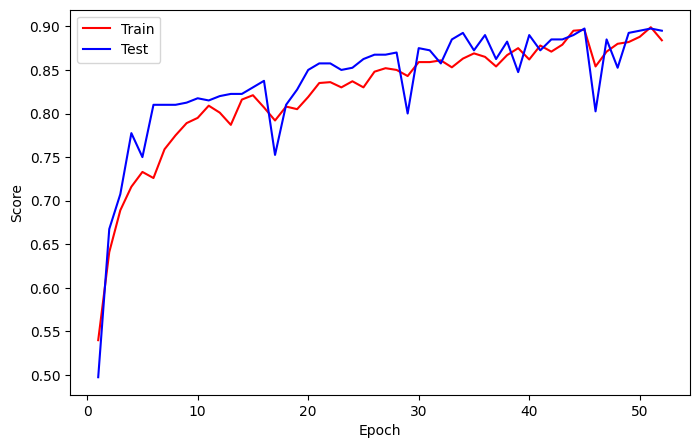

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 0.2462 | Test_cost  = 0.2576 | Train_score = 0.8960 | Test_score = 0.8875 |
==> EarlyStop patience =  8 | Best test_score: 0.8975
==> Execute Early Stopping at epoch: 53 | Best test_score: 0.8975
==> Best model is saved at model


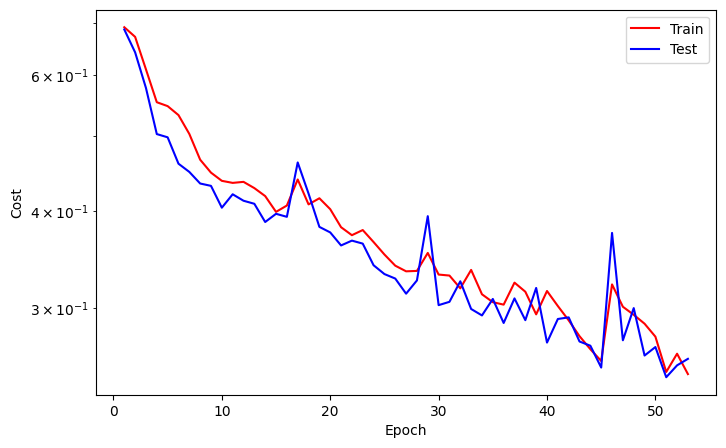

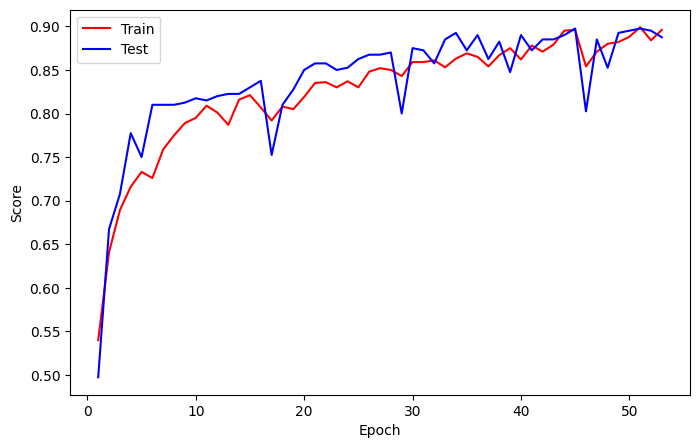

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 0.2405 | Test_cost  = 0.2461 | Train_score = 0.9010 | Test_score = 0.9000 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        if w.is_alive():self._shutdown_workers()

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

AssertionError  File "/usr/lib/python3.10/multiprocessing/proce

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 0.2305 | Test_cost  = 0.2505 | Train_score = 0.9020 | Test_score = 0.9000 |
==> EarlyStop patience =  1 | Best test_score: 0.9000


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 0.2241 | Test_cost  = 0.2481 | Train_score = 0.9090 | Test_score = 0.8850 |
==> EarlyStop patience =  2 | Best test_score: 0.9000


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 0.2217 | Test_cost  = 0.2397 | Train_score = 0.9140 | Test_score = 0.8950 |
==> EarlyStop patience =  3 | Best test_score: 0.9000


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 0.2292 | Test_cost  = 0.2564 | Train_score = 0.9090 | Test_score = 0.8825 |
==> EarlyStop patience =  4 | Best test_score: 0.9000


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 0.2296 | Test_cost  = 0.2968 | Train_score = 0.9020 | Test_score = 0.8600 |
==> EarlyStop patience =  5 | Best test_score: 0.9000
==> Execute Early Stopping at epoch: 59 | Best test_score: 0.9000
==> Best model is saved at model


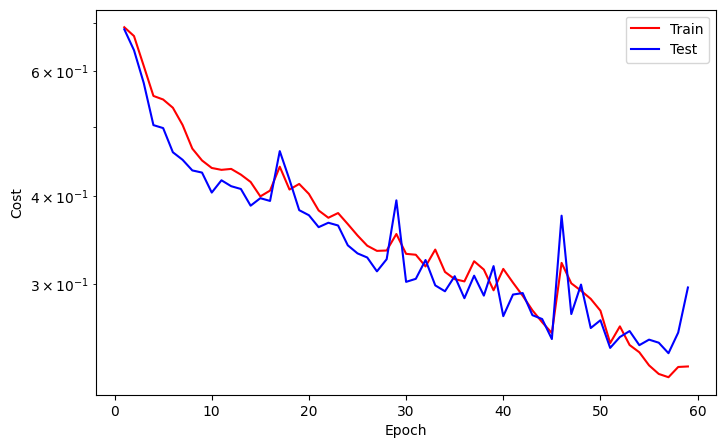

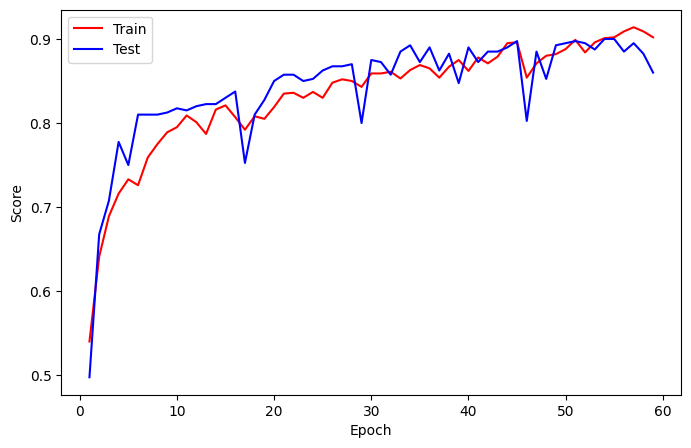

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 0.2407 | Test_cost  = 0.2866 | Train_score = 0.9080 | Test_score = 0.8750 |


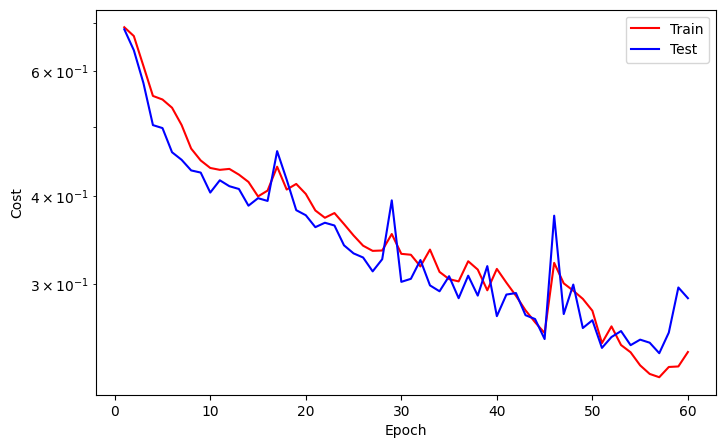

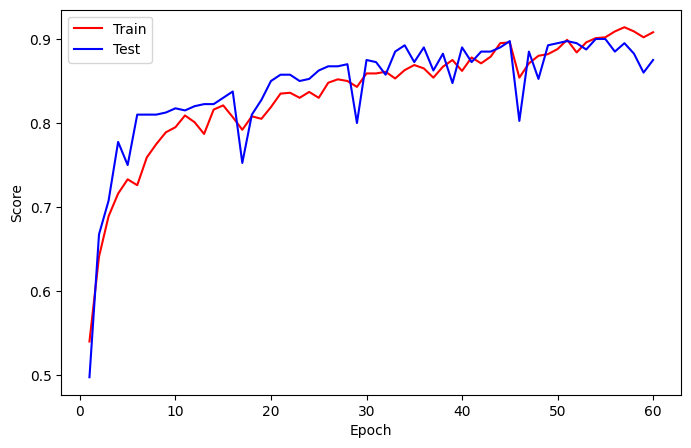

==> EarlyStop patience =  6 | Best test_score: 0.9000
==> Execute Early Stopping at epoch: 60 | Best test_score: 0.9000
==> Best model is saved at model


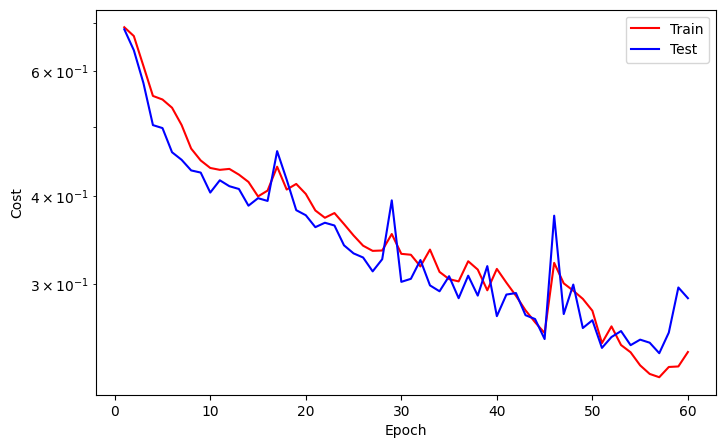

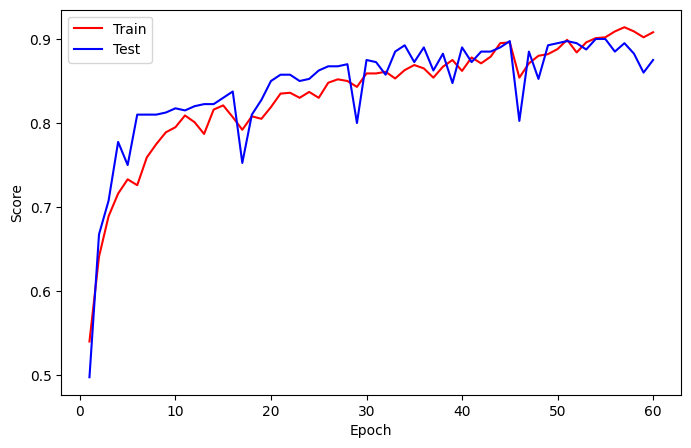

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 0.2327 | Test_cost  = 0.2427 | Train_score = 0.9000 | Test_score = 0.9050 |


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'    
self._shutdown_workers()AssertionError
:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
can only test a child process    
if w.is_alive():
  File "/usr/lib/

Train:   0%|          | 0/8 [00:00<?, ?it/s]

if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: 
can only test a child processcan only test a child process

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
AssertionErrorTraceback (most recent call last):
: can only test a child process  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Asse

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 0.2119 | Test_cost  = 0.2284 | Train_score = 0.9130 | Test_score = 0.9075 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 0.2170 | Test_cost  = 0.2310 | Train_score = 0.9070 | Test_score = 0.9025 |
==> EarlyStop patience =  1 | Best test_score: 0.9075


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 0.2355 | Test_cost  = 0.2408 | Train_score = 0.9000 | Test_score = 0.8875 |
==> EarlyStop patience =  2 | Best test_score: 0.9075


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 0.2360 | Test_cost  = 0.3011 | Train_score = 0.9120 | Test_score = 0.8825 |
==> EarlyStop patience =  3 | Best test_score: 0.9075


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 0.2377 | Test_cost  = 0.2561 | Train_score = 0.9110 | Test_score = 0.8875 |
==> EarlyStop patience =  4 | Best test_score: 0.9075


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/u

Train:   0%|          | 0/8 [00:04<?, ?it/s]

    
if w.is_alive():self._shutdown_workers()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'        assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>AssertionErrorif w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process': Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
can only test a child process
AssertionError    : self._shutdown

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 0.2212 | Test_cost  = 0.2475 | Train_score = 0.9140 | Test_score = 0.8850 |
==> EarlyStop patience =  5 | Best test_score: 0.9075
==> Execute Early Stopping at epoch: 67 | Best test_score: 0.9075
==> Best model is saved at model


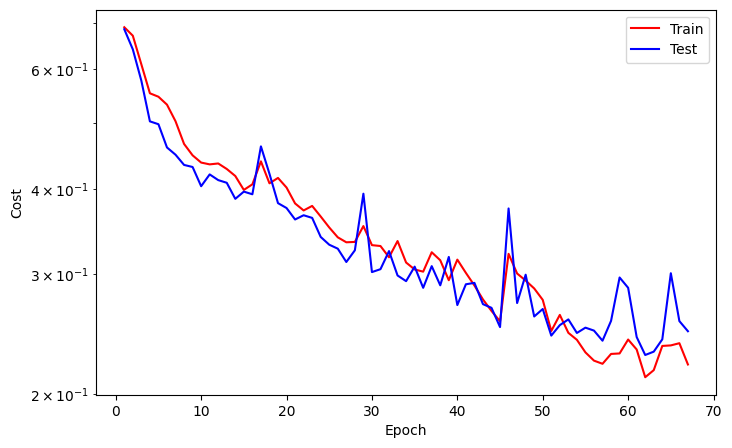

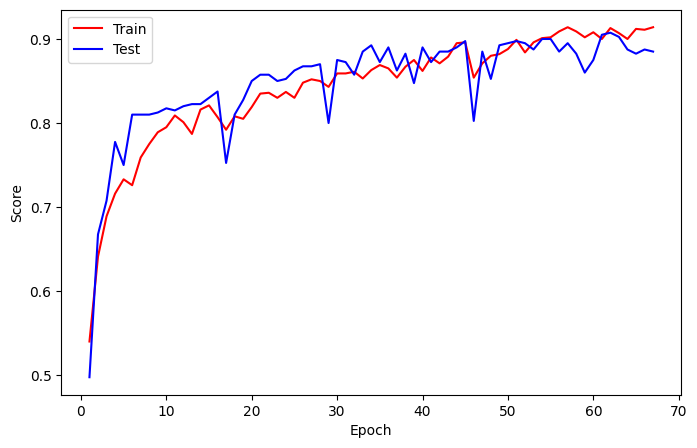

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 0.2360 | Test_cost  = 0.2483 | Train_score = 0.9040 | Test_score = 0.8850 |
==> EarlyStop patience =  6 | Best test_score: 0.9075
==> Execute Early Stopping at epoch: 68 | Best test_score: 0.9075
==> Best model is saved at model


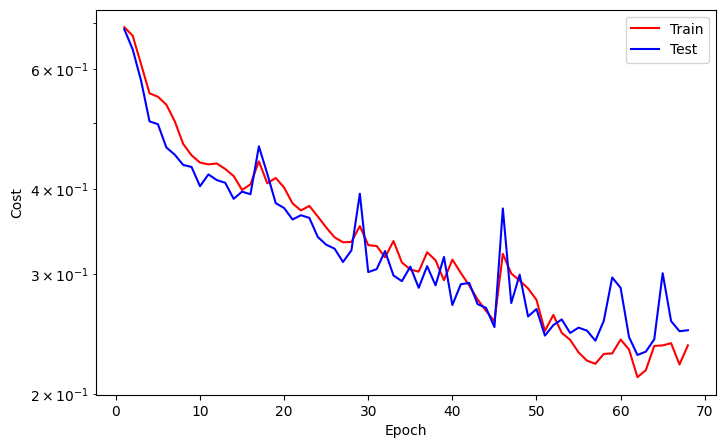

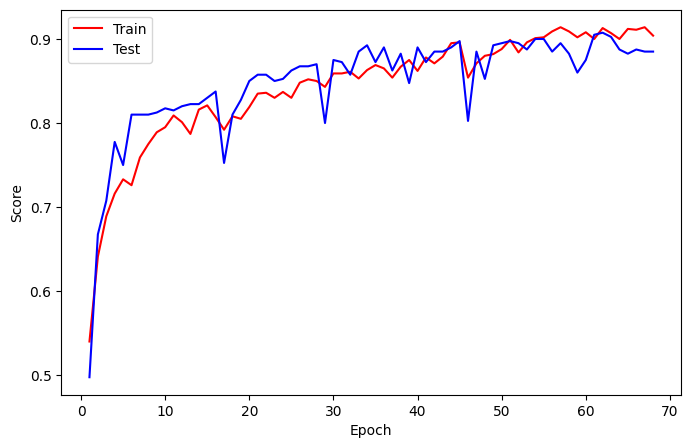

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 0.2000 | Test_cost  = 0.2276 | Train_score = 0.9120 | Test_score = 0.9100 |


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/pyth

Train:   0%|          | 0/8 [00:01<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Traceback (most recent call last):
self._shutdown_workers()Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

        Traceback (most recent call last):
self._shutdown_workers()if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
self._s

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 0.2166 | Test_cost  = 0.2733 | Train_score = 0.9030 | Test_score = 0.8650 |
==> EarlyStop patience =  1 | Best test_score: 0.9100


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 0.2320 | Test_cost  = 0.2323 | Train_score = 0.9070 | Test_score = 0.8950 |
==> EarlyStop patience =  2 | Best test_score: 0.9100


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 0.1987 | Test_cost  = 0.2259 | Train_score = 0.9210 | Test_score = 0.9125 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 0.1862 | Test_cost  = 0.2209 | Train_score = 0.9250 | Test_score = 0.9000 |
==> EarlyStop patience =  1 | Best test_score: 0.9125


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0218dd7910>    self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 0.1934 | Test_cost  = 0.2266 | Train_score = 0.9190 | Test_score = 0.9075 |
==> EarlyStop patience =  2 | Best test_score: 0.9125


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 0.1948 | Test_cost  = 0.2588 | Train_score = 0.9270 | Test_score = 0.8925 |
==> EarlyStop patience =  3 | Best test_score: 0.9125


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 0.1848 | Test_cost  = 0.2246 | Train_score = 0.9190 | Test_score = 0.9025 |
==> EarlyStop patience =  4 | Best test_score: 0.9125


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 0.1786 | Test_cost  = 0.2392 | Train_score = 0.9210 | Test_score = 0.8950 |
==> EarlyStop patience =  5 | Best test_score: 0.9125
==> Execute Early Stopping at epoch: 77 | Best test_score: 0.9125
==> Best model is saved at model


In [ ]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # checkpoint
    callback.save_checkpoint()

    # runtime plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # early stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()

<h2> Predict


In [ ]:
feature, target = next(iter(testlaoder))
feature, target = feature.to(device), target.to(device)

In [ ]:
with torch.no_grad():
    model.eval() # pindah ke eval mode
    output = model(feature) # feedforward
    preds = output.argmax(1) # cari indeks dengan probability paling tinggi
preds

In [ ]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color" : 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
    ax.axis('off');